# 📌 Problem Statement

The task is to **predict the daily audience count for each theatre** using historical data from two sources:
- **BookNow** (online bookings)
- **CinePOS** (on-site POS ticket sales)

This is a **time-series forecasting problem**, where audience numbers depend on booking trends, POS sales, theatre attributes, weekends, and holidays.


# Importing Libraries

In [1]:
# Importing core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

# Preprocessing & Metrics
from sklearn.preprocessing import  StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


# Miscellaneous
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully.")

Libraries imported successfully.


# Data Loading

In [2]:
cinepos_theaters = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_theaters/cinePOS_theaters.csv')
booknow_theaters = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_theaters/booknow_theaters.csv')
movie_theater_relation = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/movie_theater_id_relation/movie_theater_id_relation.csv')
cinepos_booking = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_booking/cinePOS_booking.csv')
booknow_booking = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_booking/booknow_booking.csv')
booknow_visits = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_visits/booknow_visits.csv')
date_info = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/date_info/date_info.csv')
sample_submission = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/sample_submission/sample_submission.csv')


print("Data loaded successfully")


Data loaded successfully


# Exploratory Data Analysis


## Dataset Overview

In [3]:
#Shape of the Datasets
datasets = {
    "CinePOS Theaters": cinepos_theaters,
    "BookNow Theaters": booknow_theaters,
    "Movie Theater Relation": movie_theater_relation,
    "CinePOS Booking": cinepos_booking,
    "BookNow Booking": booknow_booking,
    "BookNow Visits": booknow_visits,
    "Date Info": date_info,
    "Sample Submission": sample_submission
}

for name, df in datasets.items():
    print(f"{name:<25}: {df.shape}")


CinePOS Theaters         : (4690, 5)
BookNow Theaters         : (829, 5)
Movie Theater Relation   : (150, 2)
CinePOS Booking          : (1641966, 4)
BookNow Booking          : (68336, 4)
BookNow Visits           : (214046, 3)
Date Info                : (547, 2)
Sample Submission        : (38062, 2)


In [4]:
# Display top 5  datasets
display(cinepos_theaters.head())
display(booknow_theaters.head())
display(booknow_booking.head())
display(cinepos_booking.head())
display(booknow_visits.head())  #target variable (audience_count in booknow_visits)
display(movie_theater_relation.head())
display(date_info.head())


,cine_theater_id,theater_type,theater_area,latitude,longitude
0,cinePOS_05466,Other,Area_104,22.619233,78.113017
1,cinePOS_08708,Other,Area_104,22.619233,78.113017
2,cinePOS_00753,Other,Area_104,22.619233,78.113017
3,cinePOS_05776,Other,Area_104,22.619233,78.113017
4,cinePOS_07536,Other,Area_104,23.004410,79.934515


,book_theater_id,theater_type,theater_area,latitude,longitude
0,book_00093,Drama,Area_001,22.619233,78.113017
1,book_00078,Drama,Area_001,22.619233,78.113017
2,book_00291,Drama,Area_001,22.619233,78.113017
3,book_00258,Drama,Area_001,22.619233,78.113017
4,book_00212,Drama,Area_002,23.004410,79.934515


,book_theater_id,show_datetime,booking_datetime,tickets_booked
0,book_00244,2023-01-01 19:00:00,2023-01-01 16:00:00,1
1,book_00740,2023-01-01 19:00:00,2023-01-01 19:00:00,3
2,book_00740,2023-01-01 19:00:00,2023-01-01 19:00:00,6
3,book_00244,2023-01-01 20:00:00,2023-01-01 16:00:00,2
4,book_00151,2023-01-01 20:00:00,2023-01-01 01:00:00,5


,cine_theater_id,show_datetime,booking_datetime,tickets_sold
0,cinePOS_00001,2023-01-01 11:00:00,2023-01-01 09:00:00,1
1,cinePOS_00002,2023-01-01 13:00:00,2023-01-01 06:00:00,3
2,cinePOS_00003,2023-01-01 16:00:00,2023-01-01 14:00:00,2
3,cinePOS_00004,2023-01-01 17:00:00,2023-01-01 11:00:00,5
4,cinePOS_00005,2023-01-01 17:00:00,2023-01-01 03:00:00,13


,book_theater_id,show_date,audience_count
0,book_00001,2023-01-13,50
1,book_00001,2023-01-14,64
2,book_00001,2023-01-15,58
3,book_00001,2023-01-16,44
4,book_00001,2023-01-18,12


,book_theater_id,cine_theater_id
0,book_00509,cinePOS_01261
1,book_00063,cinePOS_02467
2,book_00054,cinePOS_08923
3,book_00094,cinePOS_02479
4,book_00052,cinePOS_06750


,show_date,day_of_week
0,2023-01-01,Sunday
1,2023-01-02,Monday
2,2023-01-03,Tuesday
3,2023-01-04,Wednesday
4,2023-01-05,Thursday


## Data Type Overview

In [5]:
for name, data in datasets.items():
    print(f"\n{name} — Data Types:")
    display(data.dtypes)


CinePOS Theaters — Data Types:


cine_theater_id     object
theater_type        object
theater_area        object
latitude           float64
longitude          float64
dtype: object


BookNow Theaters — Data Types:


book_theater_id     object
theater_type        object
theater_area        object
latitude           float64
longitude          float64
dtype: object


Movie Theater Relation — Data Types:


book_theater_id    object
cine_theater_id    object
dtype: object


CinePOS Booking — Data Types:


cine_theater_id     object
show_datetime       object
booking_datetime    object
tickets_sold         int64
dtype: object


BookNow Booking — Data Types:


book_theater_id     object
show_datetime       object
booking_datetime    object
tickets_booked       int64
dtype: object


BookNow Visits — Data Types:


book_theater_id    object
show_date          object
audience_count      int64
dtype: object


Date Info — Data Types:


show_date      object
day_of_week    object
dtype: object


Sample Submission — Data Types:


ID                object
audience_count     int64
dtype: object

## Missing Values

In [6]:
def check_data_health(df, name):
    print(f"\n Dataset: 🛢️{name}")
    print("Missing Values:\n", df.isnull().sum()) 
    print("-" * 30)

# Checking for each dataset
check_data_health(booknow_visits, "BookNow Visits")
check_data_health(booknow_booking, "BookNow Booking")
check_data_health(cinepos_booking, "CinePOS Booking")
check_data_health(movie_theater_relation, "Movie Theater Relation")
check_data_health(date_info, "Date Info")
check_data_health(booknow_theaters, "BookNow Theaters") # Contains Missing Value
check_data_health(cinepos_theaters, "CinePOS Theaters") # Contains Missing Value



 Dataset: 🛢️BookNow Visits
Missing Values:
 book_theater_id    0
show_date          0
audience_count     0
dtype: int64
------------------------------

 Dataset: 🛢️BookNow Booking
Missing Values:
 book_theater_id     0
show_datetime       0
booking_datetime    0
tickets_booked      0
dtype: int64
------------------------------

 Dataset: 🛢️CinePOS Booking
Missing Values:
 cine_theater_id     0
show_datetime       0
booking_datetime    0
tickets_sold        0
dtype: int64
------------------------------

 Dataset: 🛢️Movie Theater Relation
Missing Values:
 book_theater_id    0
cine_theater_id    0
dtype: int64
------------------------------

 Dataset: 🛢️Date Info
Missing Values:
 show_date      0
day_of_week    0
dtype: int64
------------------------------

 Dataset: 🛢️BookNow Theaters
Missing Values:
 book_theater_id    515
theater_type         0
theater_area         0
latitude             0
longitude            0
dtype: int64
------------------------------

 Dataset: 🛢️CinePOS Theaters

## Basic Summary Statistics

In [7]:
# Displaying descriptive statistics for numeric columns in all datasets
for name, df in datasets.items():
    print(f"\n 🛢️ Summary Statistics for {name}:")
    display(df.describe(include='all').T)


 🛢️ Summary Statistics for CinePOS Theaters:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
cine_theater_id,4690,4690,cinePOS_05466,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
theater_type,4690,3,Other,3941,NaN,NaN,NaN,NaN,NaN,NaN,NaN
theater_area,4690,119,Area_119,257,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,829.0,NaN,NaN,NaN,23.0,0.833863,22.02597,22.619233,23.00441,23.018784,26.349436
longitude,829.0,NaN,NaN,NaN,79.0,1.460388,76.112098,78.170501,79.908065,79.934515,81.743235



 🛢️ Summary Statistics for BookNow Theaters:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
book_theater_id,314,314,book_00093,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
theater_type,829,4,Other,411,NaN,NaN,NaN,NaN,NaN,NaN,NaN
theater_area,829,103,Area_003,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,829.0,NaN,NaN,NaN,23.0,0.833863,22.02597,22.619233,23.00441,23.018784,26.349436
longitude,829.0,NaN,NaN,NaN,79.0,1.460388,76.112098,78.170501,79.908065,79.934515,81.743235



 🛢️ Summary Statistics for Movie Theater Relation:


,count,unique,top,freq
book_theater_id,150,150,book_00509,1
cine_theater_id,150,150,cinePOS_01261,1



 🛢️ Summary Statistics for CinePOS Booking:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
cine_theater_id,1641966,13161,cinePOS_03019,921,NaN,NaN,NaN,NaN,NaN,NaN,NaN
show_datetime,1641966,8283,2023-12-16 19:00:00,10528,NaN,NaN,NaN,NaN,NaN,NaN,NaN
booking_datetime,1641966,10152,2023-12-12 21:00:00,907,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tickets_sold,1641966.0,NaN,NaN,NaN,4.987345,5.234901,1.0,2.0,3.0,6.0,100.0



 🛢️ Summary Statistics for BookNow Booking:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
book_theater_id,68336,301,book_00712,1832,NaN,NaN,NaN,NaN,NaN,NaN,NaN
show_datetime,68336,3866,2023-12-24 19:00:00,255,NaN,NaN,NaN,NaN,NaN,NaN,NaN
booking_datetime,68336,6351,2023-11-24 18:00:00,106,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tickets_booked,68336.0,NaN,NaN,NaN,4.425808,4.808945,1.0,2.0,3.0,5.0,100.0



 🛢️ Summary Statistics for BookNow Visits:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
book_theater_id,214046,826,book_00528,424,NaN,NaN,NaN,NaN,NaN,NaN,NaN
show_date,214046,424,2023-11-18,783,NaN,NaN,NaN,NaN,NaN,NaN,NaN
audience_count,214046.0,NaN,NaN,NaN,41.616568,32.834918,2.0,18.0,34.0,58.0,1350.0



 🛢️ Summary Statistics for Date Info:


,count,unique,top,freq
show_date,547,547,2023-01-01,1
day_of_week,547,7,Sunday,79



 🛢️ Summary Statistics for Sample Submission:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,38062,38062,book_00001_2024-03-01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
audience_count,38062.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Duplicate Checks & Unique Counts

In [8]:
# Duplicate Checks

datasets = {
    "BookNow Visits": booknow_visits,
    "BookNow Booking": booknow_booking,
    "CinePOS Booking": cinepos_booking,
    "BookNow Theaters": booknow_theaters,
    "CinePOS Theaters": cinepos_theaters,
    "Movie Theater Relation": movie_theater_relation,
    "Date Info": date_info
}

for name, df in datasets.items():
    print(f"\n 🛢️{name}")
    print(f"Duplicates: {df.duplicated().sum()}")
    print("-" * 30)



 🛢️BookNow Visits
Duplicates: 10
------------------------------

 🛢️BookNow Booking
Duplicates: 2042
------------------------------

 🛢️CinePOS Booking
Duplicates: 12541
------------------------------

 🛢️BookNow Theaters
Duplicates: 354
------------------------------

 🛢️CinePOS Theaters
Duplicates: 0
------------------------------

 🛢️Movie Theater Relation
Duplicates: 0
------------------------------

 🛢️Date Info
Duplicates: 0
------------------------------


In [9]:
# Checking unique
for name, df in datasets.items():
    print(f"\n🛢️ {name} — Unique Values:")
    print(df.nunique())
    print("-" * 30)


🛢️ BookNow Visits — Unique Values:
book_theater_id    826
show_date          424
audience_count     191
dtype: int64
------------------------------

🛢️ BookNow Booking — Unique Values:
book_theater_id      301
show_datetime       3866
booking_datetime    6351
tickets_booked        66
dtype: int64
------------------------------

🛢️ CinePOS Booking — Unique Values:
cine_theater_id     13161
show_datetime        8283
booking_datetime    10152
tickets_sold           97
dtype: int64
------------------------------

🛢️ BookNow Theaters — Unique Values:
book_theater_id    314
theater_type         4
theater_area       103
latitude           108
longitude          108
dtype: int64
------------------------------

🛢️ CinePOS Theaters — Unique Values:
cine_theater_id    4690
theater_type          3
theater_area        119
latitude            108
longitude           108
dtype: int64
------------------------------

🛢️ Movie Theater Relation — Unique Values:
book_theater_id    150
cine_theater_id    

## Drop Duplicates

In [10]:
booknow_visits = booknow_visits.drop_duplicates()
booknow_booking = booknow_booking.drop_duplicates()
cinepos_booking = cinepos_booking.drop_duplicates()
booknow_theaters = booknow_theaters.drop_duplicates()

## Convert Date Columns to Datetime Format

In [11]:
# Converting datetime columns 
booknow_visits['show_date'] = pd.to_datetime(booknow_visits['show_date'])

booknow_booking['show_datetime'] = pd.to_datetime(booknow_booking['show_datetime'])
booknow_booking['booking_datetime'] = pd.to_datetime(booknow_booking['booking_datetime'])

cinepos_booking['show_datetime'] = pd.to_datetime(cinepos_booking['show_datetime'])
cinepos_booking['booking_datetime'] = pd.to_datetime(cinepos_booking['booking_datetime'])

date_info['show_date'] = pd.to_datetime(date_info['show_date'])


#  Submission File Parsing (Extracting Date from ID)
# ID format: "TheaterID_Date"
def extract_date_from_id(row_id):
    return row_id.split('_')[-1]

sample_submission['show_date'] = pd.to_datetime(sample_submission['ID'].apply(extract_date_from_id))

print("Date columns successfully converted to datetime format.")


Date columns successfully converted to datetime format.


They’re already in a good ISO date format (YYYY-MM-DD and YYYY-MM-DD HH:MM:SS.

These date columns are Originally string object type when read by pandas, so  pd.to_datetime() converts it into a proper datetime object  (datetime64)

In [12]:
# Unique theater IDs 
print("🎬 Unique BookNow Theaters:", booknow_theaters['book_theater_id'].nunique())
print("🎦 Unique CinePOS Theaters:", cinepos_theaters['cine_theater_id'].nunique())

# Checking mapping between BookNow and CinePOS
print("\n🔗 Mapping between BookNow and CinePOS Theaters:") # Links BookNow theaters ↔ CinePOS theaters.
display(movie_theater_relation.head())
print(f"Total Mappings: {movie_theater_relation.shape[0]}")


🎬 Unique BookNow Theaters: 314
🎦 Unique CinePOS Theaters: 4690

🔗 Mapping between BookNow and CinePOS Theaters:


,book_theater_id,cine_theater_id
0,book_00509,cinePOS_01261
1,book_00063,cinePOS_02467
2,book_00054,cinePOS_08923
3,book_00094,cinePOS_02479
4,book_00052,cinePOS_06750


Total Mappings: 150


.nunique() counts how many distinct theaters are in each platform.

This gives clarity about dataset size and how many IDs we need to map/merge.
Mapping is essential because both platforms refer to the same real-world theater using different IDs.

## Basic Summary of Audience Data


In [13]:

# Summary statistics for the main target variable
booknow_visits.describe(include='all')

# Extract date range and unique theaters
min_date = booknow_visits['show_date'].min()
max_date = booknow_visits['show_date'].max()
num_theaters = booknow_visits['book_theater_id'].nunique()

print(f"\n📅 Data covers from {min_date.date()} to {max_date.date()}")
print(f"🏛️ Total unique BookNow theaters: {num_theaters}")



📅 Data covers from 2023-01-01 to 2024-02-28
🏛️ Total unique BookNow theaters: 826


#  MERGING & FEATURE ENGINEERING

In [14]:
# SETUP TRAIN & TEST SHELLS
train = booknow_visits.copy()
test = sample_submission.copy()

# Parse Test IDs (Format: TheaterID_Date)
test['book_theater_id'] = test['ID'].apply(lambda x: '_'.join(x.split('_')[:-1]))

print(f"Train: {train.shape}, Test: {test.shape}")


Train: (214036, 3), Test: (38062, 4)


In [15]:
# Feature Extraction for Date Components 

def add_basic_features(df):
    df['day_of_week'] = df['show_date'].dt.dayofweek  # 0=Monday, 6=Sunday Extracts weekday as a number
    df['day_name'] = df['show_date'].dt.day_name() #  # Extracts the weekday name
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int) #Creates a binary feature: 1 for weekend and 0 otherwise
    df['month'] = df['show_date'].dt.month #  Extract Month
    df['year'] = df['show_date'].dt.year#Extract Year
    df['day'] = df['show_date'].dt.day # Extracts the day of the month (1–31)
    df['week'] = df['show_date'].dt.isocalendar().week.astype(int) # Extracts week number (1–52)
    df['quarter'] = df['show_date'].dt.quarter # Extracts the quarter: Q1, Q2, Q3, Q4
    
    # Merge Theater Metadata
    df = df.merge(booknow_theaters, on='book_theater_id', how='left')
    
    #  Merge Calendar Info
    # FIX: We drop 'day_of_week' from date_info to prevent _x/_y duplicates
    cols_to_use = [c for c in date_info.columns if c != 'day_of_week']
    df = df.merge(date_info[cols_to_use], on='show_date', how='left')
    
    return df

train = add_basic_features(train)
test = add_basic_features(test)
print("Date & Metadata features added")

Date & Metadata features added


## Booking Aggregation

In [16]:
# Group bookings by Theater + Date
booknow_booking['show_date'] = booknow_booking['show_datetime'].dt.floor('D')
booking_agg = booknow_booking.groupby(['book_theater_id', 'show_date']).agg({
    'tickets_booked': ['sum', 'count']
}).reset_index()
booking_agg.columns = ['book_theater_id', 'show_date', 'total_bookings', 'booking_count']

# Merge to Train & Test
train = train.merge(booking_agg, on=['book_theater_id', 'show_date'], how='left')
test = test.merge(booking_agg, on=['book_theater_id', 'show_date'], how='left')

# Fill missing bookings with 0 (No booking log = 0 bookings)
train['total_bookings'] = train['total_bookings'].fillna(0)
train['booking_count'] = train['booking_count'].fillna(0)
test['total_bookings'] = test['total_bookings'].fillna(0)
test['booking_count'] = test['booking_count'].fillna(0)


Booking aggregation combines all raw booking entries for each theater and each date, and summarizing them into meaningful numerical features.

Raw booking logs have multiple rows per day, which the model cannot directly use.

Aggregation converts messy booking logs into usable numeric features.

Helps model learn:

How many people booked online

How frequently booking happens

Trends in online booking intensity

**Features Created:**
1.  **`total_bookings` (Sum):** The total number of tickets booked online. This serves as a strong "floor" for the total audience count (since Audience ≥ Online Bookings).
2.  **`booking_count` (Frequency):** The total number of booking transactions. This indicates traffic intensity and demand.

**Handling Missing Data:**
*   If a theater-date combination does not appear in the booking logs, it implies **zero** online bookings occurred. Therefore, we impute missing values with `0`.

##  ADVANCED STATISTICS (Trend, Rule, Volatility)


In [17]:
# A. Recent Trend (Last 30 Days Mean)
cutoff_date = train['show_date'].max() - pd.Timedelta(days=30)
recent_trend = train[train['show_date'] > cutoff_date].groupby('book_theater_id')['audience_count'].mean().reset_index()
recent_trend.columns = ['book_theater_id', 'recent_trend']

# B. Day-of-Week Rule (Theater x Day Average)
rule_dow = train.groupby(['book_theater_id', 'day_of_week'])['audience_count'].mean().reset_index()
rule_dow.columns = ['book_theater_id', 'day_of_week', 'rule_dow']

# C. Theater Volatility & Count (Std Dev & History Length)
theater_stats = train.groupby('book_theater_id')['audience_count'].agg(
    theater_std='std',
    theater_count='count'
).reset_index()

rule_dow: A theater-level weekly behavior feature capturing the average audience count for each theater on each day of the week. It helps the model learn typical weekday/weekend patterns at a granular level.


To capture complex patterns beyond simple dates, we engineer three types of target-based features:

1.  **Recent Trend (`Momentum`):**
    *   Calculates the average audience count for the **last 30 days** only.
    *   *Insight:* Captures the current "momentum" or popularity of a theater, which is often more predictive than long-term historical averages.

2.  **Day-of-Week Signature (`rule_dow`):**
    *   Calculates the average audience for a specific Theater + Day of Week combination (e.g., "Theater_101 on Fridays").
    *   *Insight:* Captures the unique weekly cycle of each location (e.g., some theaters are weekend hotspots, others are busy on discount weekdays).

3.  **Volatility & Volume (`theater_std`, `theater_count`):**
    *   **Standard Deviation:** Measures how inconsistent the audience numbers are. High variance implies a harder-to-predict theater.
    *   **Count:** Represents the amount of historical data available, acting as a confidence weight for the model.

In [18]:
# Merge into TRAIN
train = train.merge(recent_trend, on='book_theater_id', how='left')
train = train.merge(rule_dow, on=['book_theater_id', 'day_of_week'], how='left')
train = train.merge(theater_stats, on='book_theater_id', how='left')

# Merge into TEST
test = test.merge(recent_trend, on='book_theater_id', how='left')
test = test.merge(rule_dow, on=['book_theater_id', 'day_of_week'], how='left')
test = test.merge(theater_stats, on='book_theater_id', how='left')


In [19]:
global_mean = train['audience_count'].mean()

# Fill NaNs in Train
train['recent_trend'] = train['recent_trend'].fillna(global_mean)
train['rule_dow'] = train['rule_dow'].fillna(train['recent_trend'])
train['theater_std'] = train['theater_std'].fillna(0)
train['theater_count'] = train['theater_count'].fillna(0)

# Fill NaNs in Test
test['recent_trend'] = test['recent_trend'].fillna(global_mean)
test['rule_dow'] = test['rule_dow'].fillna(test['recent_trend'])
test['theater_std'] = test['theater_std'].fillna(0)
test['theater_count'] = test['theater_count'].fillna(0)

global_mean is the overall average audience count across the entire training dataset.

In [20]:
#For Data Visualization
booknow_merged = train.copy()

## Data Visualization

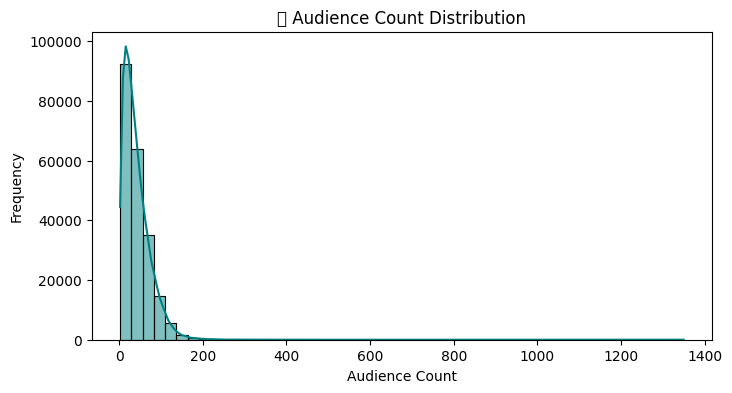

In [21]:
# Audience Count Distribution (Target Variable)

plt.figure(figsize=(8,4))
sns.histplot(booknow_visits['audience_count'], bins=50, kde=True,color='teal')
plt.title("🎟️ Audience Count Distribution")
plt.xlabel("Audience Count")
plt.ylabel("Frequency")
plt.show()


### 📊 Insights

- The distribution is **highly right-skewed**, with most audience counts concentrated between **0 and 150**.
- A long tail extends toward **higher audience values (up to ~1400)**, indicating the presence of rare but very high-attendance shows.
- The majority of data points fall in the lower range, showing that **small to medium audiences are far more common** than large crowds.
- This skewness suggests that applying **log transformation** or using models robust to skewed data may improve prediction performance

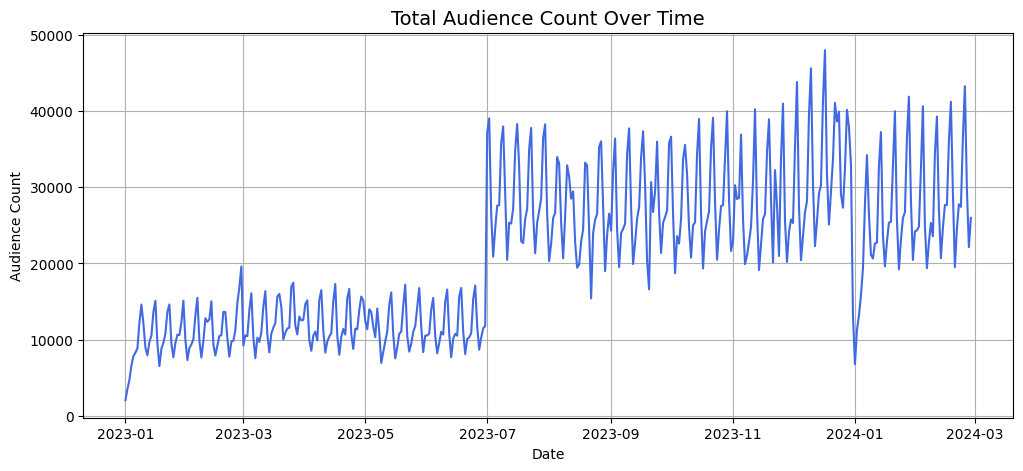

In [22]:
# 📊 Visualizing Audience Trends Over Time


plt.figure(figsize=(12, 5))
daily_audience = booknow_visits.groupby('show_date')['audience_count'].sum().reset_index()
plt.plot(daily_audience['show_date'], daily_audience['audience_count'], color='royalblue')
plt.title("Total Audience Count Over Time", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Audience Count")
plt.grid(True)
plt.show()


### 📈 Insights

- The time series shows a **clear upward shift** around mid-2023, indicating a strong increase in overall audience demand.
- Daily audience counts exhibit **regular cyclical patterns**, reflecting consistent weekly seasonality (weekdays vs weekends).
- The variability of audience counts increases significantly after the mid-2023 jump, suggesting **higher overall traffic and more volatility**.
- A temporary **dip at the start of 2024** is visible, likely due to external factors such as holidays or seasonal slowdowns.
- Overall, the trend highlights strong **growth over time**, making temporal features (e.g., `week`, `month`, `recent_trend`) crucial for accurate forecasting.


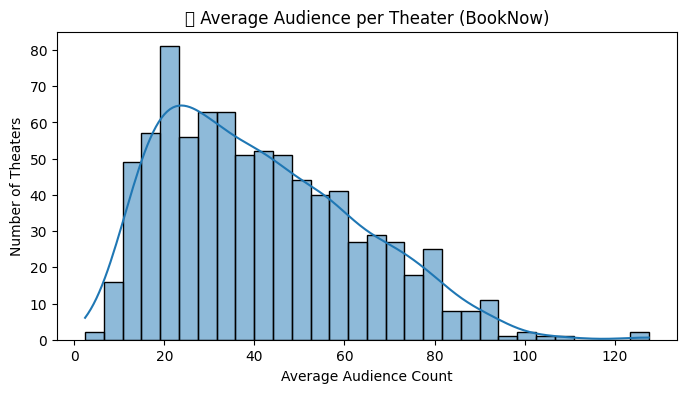

In [23]:
theater_trend = booknow_visits.groupby('book_theater_id')['audience_count'].mean().reset_index()

plt.figure(figsize=(8,4))
sns.histplot(theater_trend['audience_count'], bins=30, kde=True)
plt.title("🎭 Average Audience per Theater (BookNow)")
plt.xlabel("Average Audience Count")
plt.ylabel("Number of Theaters")
plt.show()


### 🎞️  Insights

- The distribution is **right-skewed**, meaning most theaters have moderate audience counts while a small number achieve very high averages.
- The majority of theaters fall between **20–50 average audience**, indicating a typical mid-range performance.
- A noticeable long tail extends toward **80–120+**, representing a few high-performing theaters that consistently attract large crowds.


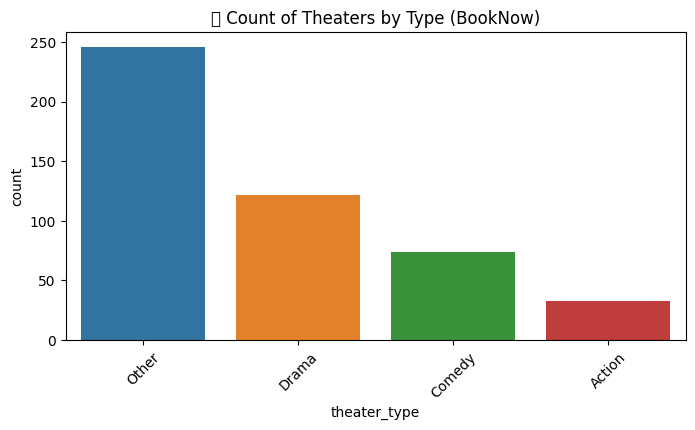

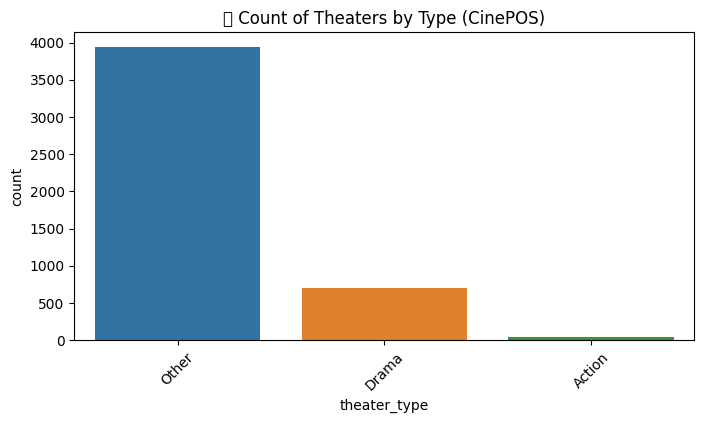

In [24]:
plt.figure(figsize=(8,4))
sns.countplot(data=booknow_theaters, x='theater_type', order=booknow_theaters['theater_type'].value_counts().index)
plt.title("🎬 Count of Theaters by Type (BookNow)")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8,4))
sns.countplot(data=cinepos_theaters, x='theater_type', order=cinepos_theaters['theater_type'].value_counts().index)
plt.title("🎞️ Count of Theaters by Type (CinePOS)")
plt.xticks(rotation=45)
plt.show()


### 🎭 Insights (BookNow vs CinePOS)

- In both datasets, **“Other” theater types dominate**, 
- **Drama theaters** form the second-largest group in both sources, showing consistent representation across platforms.
- **Comedy and Action theaters** are relatively few in BookNow, while CinePOS shows almost **no Comedy and very few Action** entries.
- The significant imbalance across categories suggests that **theater_type is highly skewed**


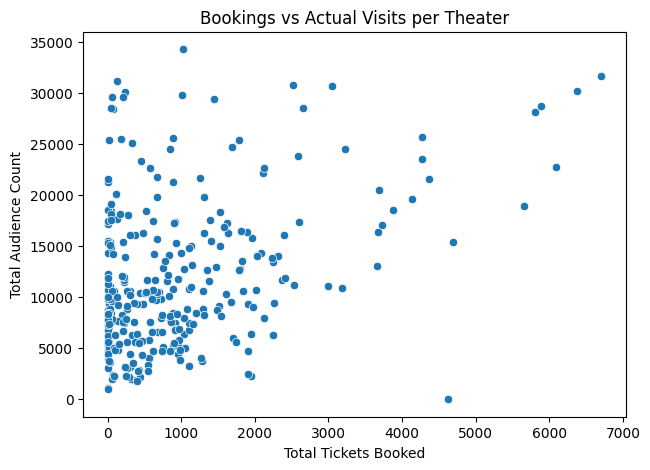

In [25]:
combined = booknow_booking.groupby('book_theater_id')['tickets_booked'].sum().reset_index()
combined = combined.merge(booknow_visits.groupby('book_theater_id')['audience_count'].sum().reset_index(),
                          on='book_theater_id', how='inner')

plt.figure(figsize=(7, 5))
sns.scatterplot(x='tickets_booked', y='audience_count', data=combined)
plt.title("Bookings vs Actual Visits per Theater")
plt.xlabel("Total Tickets Booked")
plt.ylabel("Total Audience Count")
plt.show()


### 🎟️ Insights

- The plot shows a **general upward trend**, meaning theaters with more online bookings tend to have higher actual visit counts.
- At the same time, the points are widely scattered, showing **large variation** in attendance even for similar booking numbers.
- This indicates that **walk-ins contribute significantly**, especially for theaters where visits far exceed bookings.
- A few theaters stand out as **high-attendance outliers**, reaching 20,000–35,000 visits despite only 4,000–7,000 bookings.


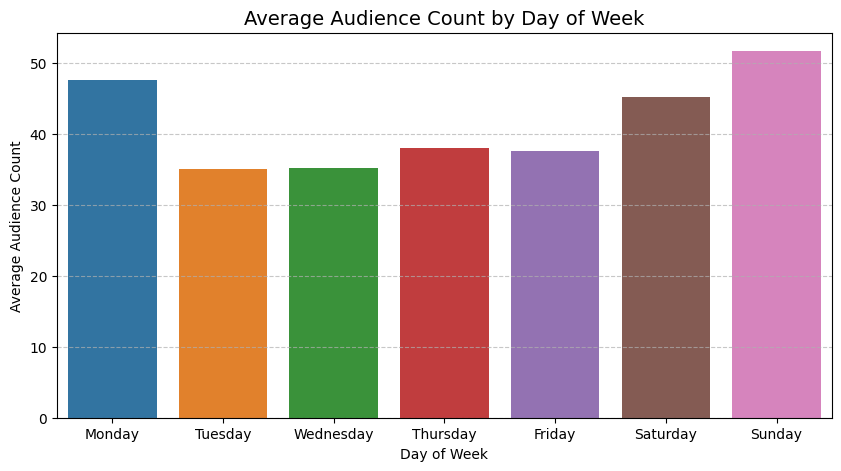

In [26]:
# 📊 Audience Count by Day of Week (using day_name)

plt.figure(figsize=(10, 5))

# group by day_name (string)
df_plot = booknow_merged.groupby('day_name')['audience_count'].mean().reset_index()

sns.barplot(
    x='day_name',
    y='audience_count',
    data=df_plot,
    order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
)

plt.title("Average Audience Count by Day of Week", fontsize=14)
plt.ylabel("Average Audience Count")
plt.xlabel("Day of Week")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()


### 📆 Insights

- **Sunday has the highest average audience**, followed by **Saturday**, confirming strong weekend demand.
- **Monday also shows relatively high attendance**, likely due to spillover from weekend trends or promotional patterns.
- Mid-week days (**Tuesday, Wednesday, Thursday**) show the lowest audience levels, indicating typical weekday slowdowns.
- **Friday starts the weekend uplift**, showing a clear transition in audience behavior.
- Overall, the trend highlights strong **weekend-centric cinema activity**, which is valuable for both modeling (`day_of_week`, `is_weekend`)


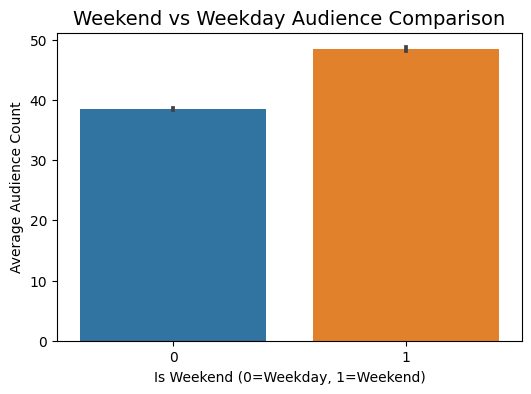

In [27]:
# 🗓️ Weekend vs Weekday Comparison

plt.figure(figsize=(6, 4))
sns.barplot(
    x='is_weekend',
    y='audience_count',
    data=booknow_merged,  
    estimator=np.mean
)
plt.title("Weekend vs Weekday Audience Comparison", fontsize=14)
plt.xlabel("Is Weekend (0=Weekday, 1=Weekend)")
plt.ylabel("Average Audience Count")
plt.show()

### 📅  Insights

- **Weekend audience counts are significantly higher** than weekday counts, showing a clear behavior shift in viewing patterns.
- The average audience increases from about **38 on weekdays to nearly 49 on weekends**, indicating stronger demand during leisure days.
- This confirms that **weekend effect is an important predictor** and should be captured in the model through features like `is_weekend` and `day_of_week`.


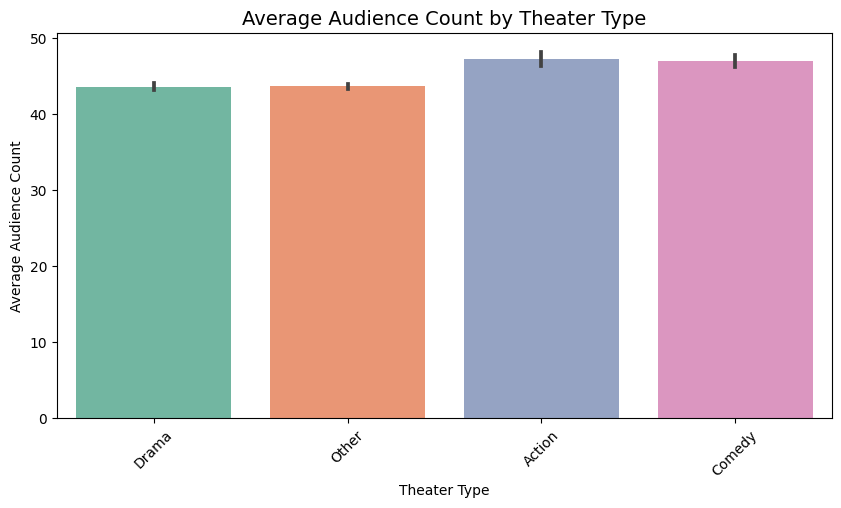

In [28]:
# 🏛️ Audience Trends by Theater Type

plt.figure(figsize=(10, 5))
sns.barplot(
    x='theater_type',
    y='audience_count',
    data=booknow_merged,
    estimator=np.mean,
    palette='Set2'
)
plt.title("Average Audience Count by Theater Type", fontsize=14)
plt.xlabel("Theater Type")
plt.ylabel("Average Audience Count")
plt.xticks(rotation=45)
plt.show()

### 🎭 Insights

- **Action and Comedy theaters have the highest average audience counts**, suggesting they attract larger and more consistent crowds.
- **Drama and Other categories show slightly lower averages**, indicating a more moderate but stable audience.
- The overall differences are **not extremely large**, implying that audience turnout is fairly balanced across genres.

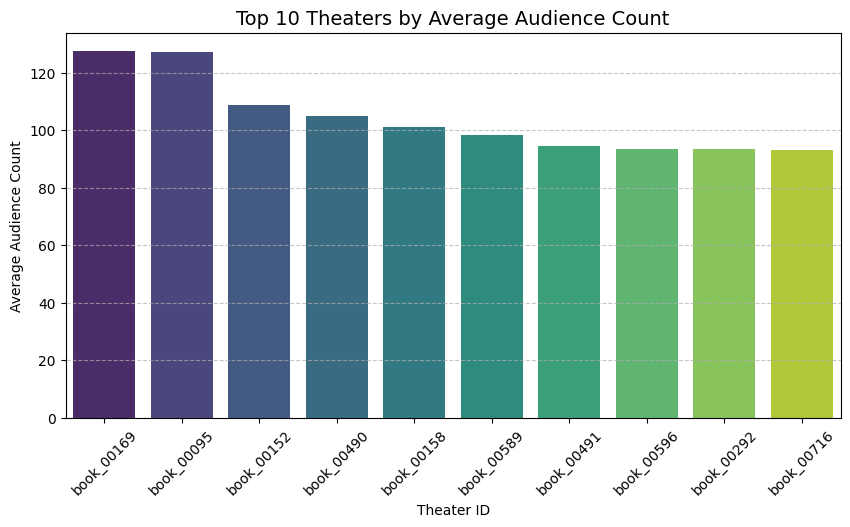

In [29]:
# 🏛️ Top 10 Theaters by Average Audience Count

#Group by theater and calculate average audience
theater_avg = (
    booknow_visits.groupby('book_theater_id')['audience_count']
    .mean()
    .reset_index()
    .sort_values(by='audience_count', ascending=False)
)

# Pick top 10 theaters
top10_theaters = theater_avg.head(10)

# Merge with theater info for labels
top10_theaters = top10_theaters.merge(booknow_theaters, on='book_theater_id', how='left')

# Plot the results
plt.figure(figsize=(10,5))
sns.barplot(
    x='book_theater_id',
    y='audience_count',
    data=top10_theaters,
    palette='viridis'
)
plt.title("Top 10 Theaters by Average Audience Count", fontsize=14)
plt.xlabel("Theater ID")
plt.ylabel("Average Audience Count")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### 🔍  Insights


*   **The Leaders:** Theaters `book_00169` and `book_00095` are the clear frontrunners, with average audience counts significantly higher than the rest. These are likely prime locations or large multiplexes that consistently draw big crowds.
*   **A "Tiered" Performance:** There seems to be a slight drop-off after the top 2, followed by a relatively consistent performance among the next 8 theaters (from `book_00152` to `book_00716`). This suggests a tier of "very high performing" theaters followed by a larger group of "high performing" ones.

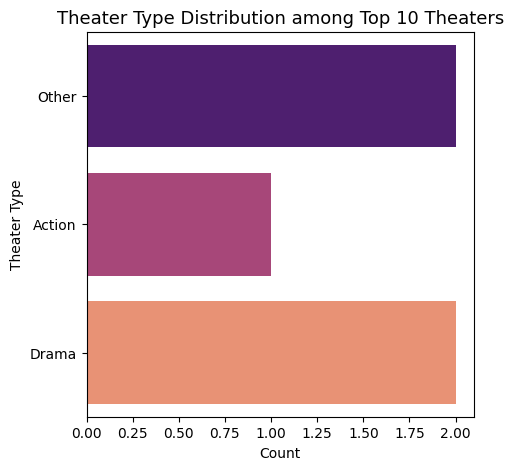

In [30]:
# 🎬 Top 10 Theaters by Average Audience (with Type Distribution)

# Compute average audience count per theater
theater_avg = (
    booknow_visits.groupby('book_theater_id')['audience_count']
    .mean()
    .reset_index()
    .sort_values(by='audience_count', ascending=False)
)

# Select top 10
top10 = theater_avg.head(10)

# Merge with theater metadata to get type/area info
top10_merged = top10.merge(booknow_theaters, on='book_theater_id', how='left')


# Theater type distribution among top 10
plt.figure(figsize=(5,5))
sns.countplot(y='theater_type', data=top10_merged, palette='magma')
plt.title("Theater Type Distribution among Top 10 Theaters", fontsize=13)
plt.xlabel("Count")
plt.ylabel("Theater Type")
plt.show()

### 🎭 Insights

- **Drama theaters appear most frequently** among the top-performing theaters, suggesting they attract a more consistent or larger audience.
- **Action theaters are less represented**, indicating either fewer action-focused venues or lower average performance compared to drama theaters.
- **"Other" category theaters also have a strong presence**, showing that mixed-genre or non-standard theater types can still perform competitively.


## Statistical Analysis

### Target variable analysis

In [31]:
booknow_visits['audience_count'].describe()

count    214036.000000
mean         41.617728
std          32.835180
min           2.000000
25%          18.000000
50%          34.000000
75%          58.000000
max        1350.000000
Name: audience_count, dtype: float64

In [32]:
f"Missing values in target: {booknow_visits['audience_count'].isnull().sum()}"

'Missing values in target: 0'

# Data Cleaning/Preprocessing

## Outlier Capping & Handling missing values

In [33]:
# Define Capping Function
def cap_outliers(df):
    # Calculate 1st and 99th percentile per theater
    # We use unstack to create a lookup table of bounds
    bounds = df.groupby('book_theater_id')['audience_count'].quantile([0.01, 0.99]).unstack()
    bounds.columns = ['low', 'high']
    
    # Merge bounds back to the dataframe
    df = df.merge(bounds, on='book_theater_id', how='left')
    
    # Clip values
    # If a theater has very little data (NaN bounds), we skip capping for it
    df['audience_count'] = df.apply(
        lambda x: np.clip(x['audience_count'], x['low'], x['high']) 
        if not pd.isna(x['low']) else x['audience_count'], axis=1
    )
    return df.drop(columns=['low', 'high'])

# Apply to TRAIN only
train = cap_outliers(train)

print("✅ Outliers Capped (1% - 99%).")


# Fill any remaining NaNs with 0 
# (e.g., if a new theater has no lat/long or no bookings)
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

✅ Outliers Capped (1% - 99%).


**Methodology:**
  **Per-Theater Capping (1st - 99th Percentile):**
    *   Audience counts vary significantly by theater capacity. A "high" count for a small theater is low for a large one.
    *   We calculate the 1st and 99th percentile boundaries *individually for each theater*.
    *   Values falling outside this range are "clipped" to these boundaries. This prevents extreme anomalies (e.g., data errors or one-off mega-events) from skewing the model's learning process.

## Encoding & Scaling

In [34]:
# Define Feature Groups
target_col = 'audience_count'
cat_features = ['book_theater_id', 'theater_type', 'theater_area', 'day_name']

# Numerical Columns 
exclude_cols = ['ID', 'show_date', 'audience_count', 'show_datetime', 'booking_datetime']
num_features = [c for c in train.columns if c not in cat_features and c not in exclude_cols]

# This prevents the 'int vs str' mixed type error
print("Fixing mixed data types...")
for col in cat_features:
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)

print(f"Categorical Features: {len(cat_features)}")
print(f"Numerical Features: {len(num_features)}")

Fixing mixed data types...
Categorical Features: 4
Numerical Features: 15


In [35]:
# Define Transformers
# For Numbers: Scale to mean=0, std=1
num_transformer = StandardScaler()

# For Categories: Convert to Integer IDs (0, 1, 2...)
# handle_unknown='use_encoded_value' allows unknown categories in test set (assigned -1)
cat_transformer = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Create the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ],
    verbose_feature_names_out=False  # Keeps original column names
)

In [36]:
 # Define Features (X) and Target (y)
X = train.drop(columns=exclude_cols, errors='ignore')
y = train[target_col]

X_test = test.drop(columns=exclude_cols, errors='ignore')

In [37]:
# Fit on TRAIN
X_processed_array = preprocessor.fit_transform(X)
# Transform TEST
X_test_processed_array = preprocessor.transform(X_test)

# Convert back to DataFrame (Critical for Model Feature Names)
# We need to get the column names in the correct order from the transformer
all_feature_names = num_features + cat_features 
# (ColumnTransformer usually outputs num then cat based on order above)

X_processed = pd.DataFrame(X_processed_array, columns=all_feature_names)
X_test_processed = pd.DataFrame(X_test_processed_array, columns=all_feature_names)

print("Encoding & Scaling Complete.")
print(f"Processed Train Shape: {X_processed.shape}")
print(f"Processed Test Shape: {X_test_processed.shape}")

Encoding & Scaling Complete.
Processed Train Shape: (214036, 19)
Processed Test Shape: (38062, 19)


## Train-Validation Split

In [38]:

# TRAIN-VALIDATION SPLIT (TIME-BASED)
print("⏳ splitting data based on Time...")

#  Determine the Cutoff Date (80% mark)
split_date = train['show_date'].quantile(0.8)

print(f"Split Date: {split_date.date()}")

# We use the original 'train' df to check dates, but split the 'X_processed' data
train_idx = train['show_date'] < split_date
val_idx = train['show_date'] >= split_date

# 3. Split the Processed Data
X_train_split = X_processed[train_idx]
y_train_split = y[train_idx]

X_val_split = X_processed[val_idx]
y_val_split = y[val_idx]
print(f"Training Set:   {X_train_split.shape[0]} rows (Ends {train[train_idx]['show_date'].max().date()})")
print(f"Validation Set: {X_val_split.shape[0]} rows (Starts {train[val_idx]['show_date'].min().date()})")

⏳ splitting data based on Time...
Split Date: 2023-12-26
Training Set:   170838 rows (Ends 2023-12-25)
Validation Set: 43198 rows (Starts 2023-12-26)


# Model Building

In [39]:
# SETUP FOR MODEL TRAINING
X_train = X_train_split
y_train = y_train_split
X_val = X_val_split
y_val = y_val_split

# 📏 Evaluation function
def evaluate_model(name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    print(f"✅ {name} | R²: {r2:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f}")
    return r2, mae, rmse

## LightGBM

In [40]:
print("Training LightGBM...")

lgbm_model = lgb.LGBMRegressor(
    objective='regression',  # 'regression_l1' (MAE) or 'regression' (MSE)
    metric='rmse',
    n_estimators=1000,
    learning_rate=0.05,
    n_jobs=-1,
    random_state=42,
    verbose=-1
)

lgbm_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(100)]
)
y_pred_lgbm = lgbm_model.predict(X_val)
y_pred_lgbm = np.maximum(y_pred_lgbm, 0) # Floor at 0
evaluate_model("LightGBM", y_val, y_pred_lgbm)

Training LightGBM...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	valid_0's rmse: 20.0435
✅ LightGBM | R²: 0.5838 | MAE: 14.3889 | RMSE: 20.0435


(0.5837793789276148, 14.388922081745251, 20.04354081179436)

## XGBoost Model

In [41]:
print("Training XGBoost...")

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    early_stopping_rounds=100, 
    n_jobs=-1,
    random_state=42
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)
y_pred_xgb = xgb_model.predict(X_val)
y_pred_xgb = np.maximum(y_pred_xgb, 0) # Safety: Floor at 0
evaluate_model("XGBoost", y_val, y_pred_xgb)

Training XGBoost...
✅ XGBoost | R²: 0.6021 | MAE: 14.1960 | RMSE: 19.5964


(0.6021424758851512, 14.196027205201993, 19.596406335920218)

## Random Forest Regressor

In [42]:
rf = RandomForestRegressor(
    n_estimators=100,  # Keeping it lighter for speed
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_val)
y_pred_rf = np.maximum(y_pred_rf, 0)
evaluate_model("Random Forest", y_val, y_pred_rf)


✅ Random Forest | R²: 0.4690 | MAE: 16.0832 | RMSE: 22.6384


(0.46903596468810604, 16.083232278367262, 22.63837245781495)

## Linear Regression (baseline linear model)

In [43]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_val)
y_pred_lr = np.maximum(y_pred_lr, 0)
evaluate_model("Linear Regression", y_val, y_pred_lr)



✅ Linear Regression | R²: 0.5538 | MAE: 14.2056 | RMSE: 20.7535


(0.5537698983674695, 14.205640621707877, 20.753534912284575)

In [44]:
print("\n--- Validation Metrics ---")
y_pred_lgbm = lgbm_model.predict(X_val)
r2_lgbm, mae_lgbm, rmse_lgbm = evaluate_model("LightGBM", y_val, y_pred_lgbm)

y_pred_xgb = xgb_model.predict(X_val)
r2_xgb, mae_xgb, rmse_xgb = evaluate_model("XGBoost", y_val, y_pred_xgb)

y_pred_rf = rf.predict(X_val)
r2_rf, mae_rf, rmse_rf = evaluate_model("Random Forest", y_val, y_pred_rf)

y_pred_lr = lr.predict(X_val)
r2_lr, mae_lr, rmse_lr = evaluate_model("Linear Regression", y_val, y_pred_lr)


--- Validation Metrics ---
✅ LightGBM | R²: 0.5838 | MAE: 14.3889 | RMSE: 20.0435
✅ XGBoost | R²: 0.6021 | MAE: 14.1960 | RMSE: 19.5964
✅ Random Forest | R²: 0.4690 | MAE: 16.0832 | RMSE: 22.6384
✅ Linear Regression | R²: 0.5538 | MAE: 14.2056 | RMSE: 20.7535


## Final Model Comparison

In [45]:
# Combine results for all models
results = pd.DataFrame({
    'Model': [
        'LightGBM',
        'XGBoost',
        'Random Forest',
        'Linear Regression',
    ],
    'R2': [r2_lgbm, r2_xgb, r2_rf, r2_lr],
    'MAE': [mae_lgbm, mae_xgb, mae_rf, mae_lr],
    'RMSE': [rmse_lgbm, rmse_xgb, rmse_rf, rmse_lr]
})

results = results.sort_values(by='R2', ascending=False).reset_index(drop=True)
results.style.background_gradient(cmap="Greens", subset=["R2"])

,Model,R2,MAE,RMSE
0,XGBoost,0.602142,14.196027,19.596406
1,LightGBM,0.583779,14.388922,20.043541
2,Linear Regression,0.553770,14.205641,20.753535
3,Random Forest,0.469036,16.083232,22.638372


## Hyperparameter Tuning

In [46]:
# Optimal Parameters for LightGBM
lgb_params = {
    'n_estimators': 1200,
    'learning_rate': 0.02,
    'num_leaves': 31,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'objective': 'regression',
    'metric': 'rmse',
    'n_jobs': -1,
    'random_state': 42,
    'verbose': -1
}

#  Optimal Parameters for XGBoost
xgb_params = {
    'n_estimators': 1000,
    'learning_rate': 0.02,
    'max_depth': 8,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'objective': 'reg:squarederror',
    'n_jobs': -1,
    'random_state': 42,
    'verbosity': 0
}

#  Train models on Split Data 
print("Training Best LightGBM on Split Data...")
best_model_lgbm = lgb.LGBMRegressor(**lgb_params)
best_model_lgbm.fit(X_train, y_train)

print("✅ Tuning Complete.")

Training Best LightGBM on Split Data...
✅ Tuning Complete.


# Model Evaluation & Feature Importance

Evaluating the Tuned LightGBM Model...
✅ Tuned LightGBM | R²: 0.5103 | MAE: 15.3381 | RMSE: 21.7412

Feature Importance Plot:


<Figure size 1000x800 with 0 Axes>

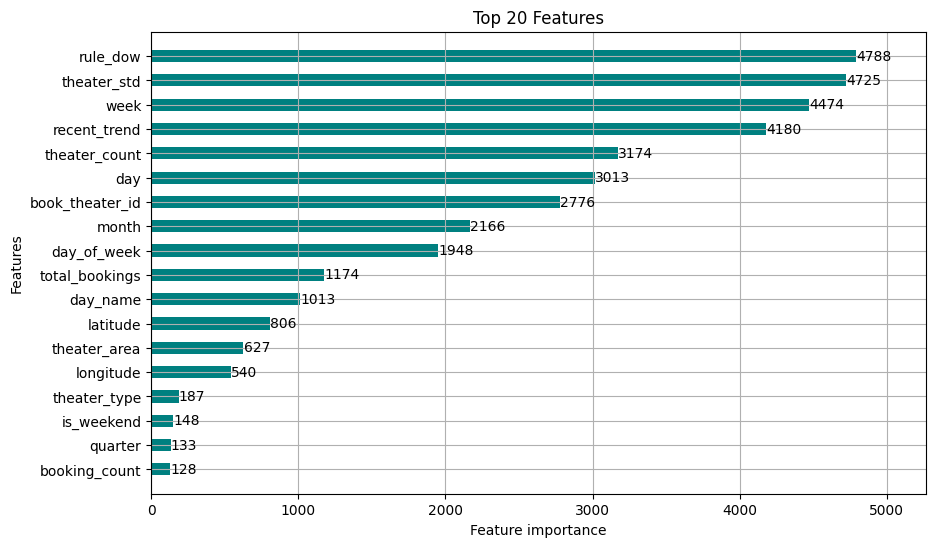

In [47]:
from lightgbm import plot_importance

print("Evaluating the Tuned LightGBM Model...")

#  Predict
y_pred_best_lgbm = best_model_lgbm.predict(X_val)

# Safety Floor (No negative predictions)
y_pred_best_lgbm = np.maximum(y_pred_best_lgbm, 0)

#  Evaluate Metrics
evaluate_model("Tuned LightGBM", y_val, y_pred_best_lgbm)

print("\nFeature Importance Plot:")
plt.figure(figsize=(10, 8))
plot_importance(best_model_lgbm, max_num_features=20, height=0.5, figsize=(10,6), title="Top 20 Features", color='teal')
plt.show()

### Insights

The Feature Importance plot highlights which variables contribute most significantly to the predictive power of our LightGBM model. Understanding these drivers is crucial for model interpretability and validating that the model is learning logical patterns.

### Key Observations:

1.  **Theater-Specific Behavior is King (`theater_std`, `rule_dow`, `theater_count`):**
    *   **`theater_std`** (Standard Deviation of attendance per theater) is the #1 most important feature. This suggests the model relies heavily on knowing *how volatile* a theater's audience is. A theater with consistently stable crowds is predicted differently than one with wild swings (e.g., due to blockbusters).
    *   **`rule_dow`** (Average attendance for that specific theater on that specific day of the week) is the #2 feature. This confirms that historical day-of-week patterns (e.g."Theater X is always busy on Fridays") are extremely predictive
    *   **`theater_count`** indicates that the *amount of historical data* we have for a theater helps the model calibrate its confidence.

2.  **Recent Trends  (`recent_trend`):**
    *   The **`recent_trend`** feature (average attendance over the last 30 days) is highly influential. This validates our strategy of capturing short-term momentum. A theater might be historically popular, but if it has been empty for the last month, the model adjusts accordingly.

3.  **Seasonality and Calendar Effects (`week`, `day`, `month`):**
    *   **`week`** is a top-tier feature, likely capturing the broader seasonality of the movie industry (e.g., summer blockbusters vs. quiet periods).
    *   **`day`** and **`month`** also play significant roles, helping the model pinpoint specific high-traffic periods like holidays or start-of-month paydays.

4.  **Booking Data (`total_bookings`):**
    *   Online bookings (`total_bookings`) are a strong predictor, but interestingly, they are *not* the #1 feature. This implies that **walk-in customers** make up a significant portion of the audience, and the model must rely on historical patterns (`rule_dow`, `recent_trend`) to fill in the gap between online bookings and total visits.

5.  **Location Features (`latitude`, `longitude`, `theater_area`):**
    *   Geographic features have moderate importance. This suggests that while location matters (e.g., city center vs. suburbs), the specific behavior of the theater itself (captured by the stats above) is more important than just where it is on a map.

## ENSEMBLE

In [48]:
# Initialize Best Models
final_lgbm = lgb.LGBMRegressor(**lgb_params)
final_xgb = xgb.XGBRegressor(**xgb_params)

# 2. Refit on FULL Data (Train + Validation)
print("Refitting LightGBM on full data...")
final_lgbm.fit(X_processed, y)

print("Refitting XGBoost on full data...")
final_xgb.fit(X_processed, y)

# 3. Predict on Test Set
pred_lgbm = final_lgbm.predict(X_test_processed)
pred_xgb = final_xgb.predict(X_test_processed)

# 4. Weighted Ensemble (50% LGBM + 50% XGB)
final_raw_preds = (0.5 * pred_lgbm) + (0.5 * pred_xgb)

Refitting LightGBM on full data...
Refitting XGBoost on full data...


# Submission File

In [49]:
# Prepare Submission DataFrame
sub_df = test[['ID', 'book_theater_id', 'show_date', 'total_bookings']].copy()
sub_df['audience_count'] = final_raw_preds

# Logic A: Floor at 0
sub_df['audience_count'] = np.maximum(sub_df['audience_count'], 0)

# Logic B: Booking Floor (Audience >= Bookings)
sub_df['audience_count'] = np.maximum(sub_df['audience_count'], sub_df['total_bookings'])

# Logic C: 3-Day Smoothing
sub_df = sub_df.sort_values(['book_theater_id', 'show_date'])
sub_df['audience_count'] = sub_df.groupby('book_theater_id')['audience_count'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

# Logic D: Round to Integer
sub_df['audience_count'] = np.round(sub_df['audience_count']).astype(int)

# 6. Save File
final_submission = sub_df[['ID', 'audience_count']]
final_submission.to_csv('submission.csv', index=False)

print("\n SUCCESS: 'submission.csv' generated!")
display(final_submission.head())


 SUCCESS: 'submission.csv' generated!


,ID,audience_count
0,book_00001_2024-03-01,39
1,book_00001_2024-03-02,57
2,book_00001_2024-03-03,59
3,book_00001_2024-03-04,51
4,book_00001_2024-03-06,37


# MILESTONE 1

In [50]:
"""
Q1: Shape of booknow_booking
booknow_booking.shape

Q2: Object columns in cinePOS_theaters
object_cols = cinepos_theaters.select_dtypes(include=['object']).columns.tolist()
len(object_cols)

Q3: Most frequent theater type
booknow_theaters['theater_type'].value_counts().index[0]

Q4: Distinct theaters in cinePOS_booking
cinepos_booking['cine_theater_id'].nunique()

Q5: Merge booknow_booking + booknow_theaters
merged1 = pd.merge(booknow_booking, booknow_theaters, on='book_theater_id', how='inner')
merged1.shape

Q6: Distinct areas in the merged dataset
merged1['theater_area'].nunique()

Q7: Merge movie_theater_id_relation + cinePOS_booking + cinePOS_theaters
temp_merge = pd.merge(theater_relation, cinepos_booking, 
                     left_on='cine_theater_id', 
                     right_on='cine_theater_id', 
                     how='inner')

final_merge = pd.merge(temp_merge, cinepos_theaters, 
                      left_on='cine_theater_id', 
                      right_on='cine_theater_id', 
                      how='inner')

# Find columns with missing values
final_merge.columns[final_merge.isnull().any()].tolist()


Q8: Date range in booknow_booking
booknow_booking['show_datetime'] = pd.to_datetime(booknow_booking['show_datetime'])
min_date = booknow_booking['show_datetime'].min().strftime('%d-%m-%Y')
max_date = booknow_booking['show_datetime'].max().strftime('%d-%m-%Y')
f"{min_date} to {max_date}"


Q9: Date range in sample_submission
sample_submission['date'] = pd.to_datetime(sample_submission['id'].str.split('_').str[-1])
min_date_test = sample_submission['date'].min().strftime('%d-%m-%Y')
max_date_test = sample_submission['date'].max().strftime('%d-%m-%Y')
f"{min_date_test} to {max_date_test}"
"""

'\nQ1: Shape of booknow_booking\nbooknow_booking.shape\n\nQ2: Object columns in cinePOS_theaters\nobject_cols = cinepos_theaters.select_dtypes(include=[\'object\']).columns.tolist()\nlen(object_cols)\n\nQ3: Most frequent theater type\nbooknow_theaters[\'theater_type\'].value_counts().index[0]\n\nQ4: Distinct theaters in cinePOS_booking\ncinepos_booking[\'cine_theater_id\'].nunique()\n\nQ5: Merge booknow_booking + booknow_theaters\nmerged1 = pd.merge(booknow_booking, booknow_theaters, on=\'book_theater_id\', how=\'inner\')\nmerged1.shape\n\nQ6: Distinct areas in the merged dataset\nmerged1[\'theater_area\'].nunique()\n\nQ7: Merge movie_theater_id_relation + cinePOS_booking + cinePOS_theaters\ntemp_merge = pd.merge(theater_relation, cinepos_booking, \n                     left_on=\'cine_theater_id\', \n                     right_on=\'cine_theater_id\', \n                     how=\'inner\')\n\nfinal_merge = pd.merge(temp_merge, cinepos_theaters, \n                      left_on=\'cine_thea

# MILESTONE 2

In [51]:
'''
# --- Q1: Bookings on same calendar day ---
# Parse datetimes
booknow_booking['booking_datetime'] = pd.to_datetime(booknow_booking['booking_datetime'])
booknow_booking['show_datetime'] = pd.to_datetime(booknow_booking['show_datetime'])

# Compare only the date parts
same_day_count = booknow_booking[
    booknow_booking['booking_datetime'].dt.date == booknow_booking['show_datetime'].dt.date
].shape[0]
print(f"Q1: Total same-day bookings: {same_day_count}")


# --- Q2: Unique calendar months ---
date_info['show_date'] = pd.to_datetime(date_info['show_date'])
# Use to_period('M') to capture Year-Month combinations (e.g., 2023-01)
unique_months = date_info['show_date'].dt.to_period('M').nunique()
print(f"Q2: Unique calendar months: {unique_months}")


# --- Q3: Percentage of bookings on Sunday ---
sunday_bookings = booknow_booking[
    booknow_booking['booking_datetime'].dt.day_name() == 'Sunday'
].shape[0]
percentage_sunday = (sunday_bookings / booknow_booking.shape[0]) * 100
print(f"Q3: Percentage of Sunday bookings: {percentage_sunday:.3f}%")


# --- Q4: Mean Latitude for 'Drama' theaters ---
drama_mean_lat = booknow_theaters[booknow_theaters['theater_type'] == 'Drama']['latitude'].mean()
print(f"Q4: Mean latitude (Drama): {drama_mean_lat:.4f}")


# --- Q5: Latitude Range ---
lat_range = booknow_theaters['latitude'].max() - booknow_theaters['latitude'].min()
print(f"Q5: Latitude Range: {lat_range:.4f}")


# --- Q6: 95th percentile of tickets_sold ---
p95_tickets = cinepos_booking['tickets_sold'].quantile(0.95)
print(f"Q6: 95th percentile ticket sales: {p95_tickets}")


# --- Q7: One-Hot Encoding Shape ---
# Identify categorical columns (object type)
categorical_cols = cinepos_theaters.select_dtypes(include=['object']).columns.tolist()

# Apply One-Hot Encoding
encoded_df = pd.get_dummies(cinepos_theaters, columns=categorical_cols)

print(f"Q7: Shape after OneHot Encoding: {encoded_df.shape}")
'''

'\n# --- Q1: Bookings on same calendar day ---\n# Parse datetimes\nbooknow_booking[\'booking_datetime\'] = pd.to_datetime(booknow_booking[\'booking_datetime\'])\nbooknow_booking[\'show_datetime\'] = pd.to_datetime(booknow_booking[\'show_datetime\'])\n\n# Compare only the date parts\nsame_day_count = booknow_booking[\n    booknow_booking[\'booking_datetime\'].dt.date == booknow_booking[\'show_datetime\'].dt.date\n].shape[0]\nprint(f"Q1: Total same-day bookings: {same_day_count}")\n\n\n# --- Q2: Unique calendar months ---\ndate_info[\'show_date\'] = pd.to_datetime(date_info[\'show_date\'])\n# Use to_period(\'M\') to capture Year-Month combinations (e.g., 2023-01)\nunique_months = date_info[\'show_date\'].dt.to_period(\'M\').nunique()\nprint(f"Q2: Unique calendar months: {unique_months}")\n\n\n# --- Q3: Percentage of bookings on Sunday ---\nsunday_bookings = booknow_booking[\n    booknow_booking[\'booking_datetime\'].dt.day_name() == \'Sunday\'\n].shape[0]\npercentage_sunday = (sunday_boo